In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random

In [2]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
# USE CNN that is pretrained on cifar10
from cifar10_models.resnet import *

model = resnet18()
weights = torch.load('state_dicts/resnet18.pt')
model.load_state_dict(weights)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Check labels of class

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)

transform = transforms.Compose([
    # transforms.Resize((crop_resolution, crop_resolution)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(cifar10_dataset, batch_size=1000, shuffle=True)


cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

Files already downloaded and verified


# Our Classmaximization Method (with gaussian blur)

In [5]:
class ClassMaxim(nn.Module):
    def __init__(self):
        super(ClassMaxim, self).__init__()
        self.x_c = nn.parameter.Parameter(torch.randn(1, 3, 32, 32))  
        self.clone = self.x_c.clone()

In [6]:
from torchvision.transforms.functional import gaussian_blur
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [7]:
clsmax = ClassMaxim()
clss = 9 # billard class

# hyperparameters
lamb = 0.1
lr = 4
sigma = 0.5
kern_size = 3
blur_frequency = 4

In [ ]:
from torchvision.transforms.functional import gaussian_blur
def gaussian_blur_channelwise(input_tensor, kernel_size, sigma):
    channels = 3
    blurred_channels = []
    for c in range(channels):
        blurred_channel = gaussian_blur(input_tensor[:, c:c+1, :, :], kernel_size=kernel_size, sigma=sigma)
        blurred_channels.append(blurred_channel)
    return torch.cat(blurred_channels, dim=1)

In [ ]:
std_tens = torch.tensor(std).reshape(-1,1,1)
mean_tens = torch.tensor(mean).reshape(-1,1,1)

plt.figure()
for i in range(40):
    # lr-=2
    # if lr <= 8:
    #     lr = 8
    plt.imshow((clsmax.x_c[0]*std_tens + mean_tens).detach().numpy().transpose(1,2,0))
    plt.show()
    for step in range(20):
        xx = clsmax.x_c[0]
        preds = model(xx.unsqueeze(0)) # cnn 1 x 3 x 32 x 32, expected dim
        preds = preds.squeeze(0)

        loss = (preds[clss] - lamb*(torch.norm(clsmax.x_c[0],p=2)))
        (loss).backward()
        
        grad = clsmax.x_c.grad #/ (torch.norm(clsmax.x_c.grad)+ 1e-5) # l2 norm, grads
        clsmax.x_c = nn.Parameter(clsmax.x_c + grad*lr) # update step, gradient ascent

        with torch.no_grad():
            # normalize between 0 and 1
            min_value = torch.min(clsmax.x_c)
            max_value = torch.max(clsmax.x_c)
            normalized_tensor = (clsmax.x_c - min_value) / (max_value - min_value)
            blurred_tensor = normalized_tensor

            # Gaussian blur
            if step % blur_frequency == 0:
                blurred_tensor = gaussian_blur_channelwise(normalized_tensor, kernel_size=kern_size, sigma=sigma)
            
            # clipping pixels with small norm
            clipped_tensor = blurred_tensor
            norms = torch.norm(blurred_tensor, dim=1, p=2)
            below_threshold = norms < 0.001
            blurred_tensor[:, :, below_threshold.squeeze(0)] = 0
            clsmax.x_c = nn.Parameter(clipped_tensor  * (max_value - min_value) + min_value)
    
    if(i < 39):
        clear_output(wait=True)
        display(plt.gcf())


In [8]:
from torchvision.transforms.functional import gaussian_blur
def gaussian_blur_channelwise(input_tensor, kernel_size, sigma):
    channels = 3
    blurred_channels = []
    for c in range(channels):
        blurred_channel = gaussian_blur(input_tensor[:, c:c+1, :, :], kernel_size=kernel_size, sigma=sigma)
        blurred_channels.append(blurred_channel)
    return torch.cat(blurred_channels, dim=1)

In [9]:
normalize = transforms.Normalize(mean, std)

def clamp_to_img(x):
  return torch.clamp(x, min=0., max=1.)

In [19]:
def activation_maxim(model, label, lamb, alpha, iters, device="cpu"):
  sigma = 1.5
  kernel_size=5
  image = torch.randn(1, 3, 32, 32).to(device)
  r = torch.rand_like(image).to(device)
  r.requires_grad_()

  for i in range(iters):
      preds = model(normalize(r)) #clamp_to_img(r)
      loss = preds[0,label] - lamb*(torch.norm(r,p=2))
      (-loss).backward()
      r.data -=  alpha * r.grad.data
      
      if i % 4 == 0:
        with torch.no_grad():
          r.data = gaussian_blur_channelwise(r, kernel_size, sigma)
          sigma*=0.99
          if sigma < 1.1:
             sigma = 1.1
          norms = torch.norm(r, dim=1, p=2)
          below_threshold = norms < 0.0001
          r.data[:, :, below_threshold.squeeze(0)] = 0
        if i%20==0:
          output_image = r.detach()
          image_np = clamp_to_img(r.detach())[0].permute(1, 2, 0).cpu().numpy()
          clear_output(wait=True)
          display(plt.gcf())
          plt.imshow(image_np)
          plt.axis('off')
          plt.show()


  return output_image

<Figure size 640x480 with 0 Axes>

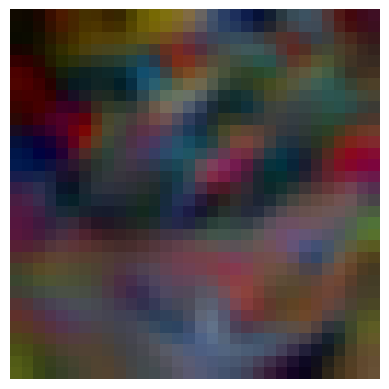

tensor([[[[ 0.1177,  0.1299,  0.0008,  ...,  0.1568,  0.3667,  0.2051],
          [ 0.2770, -0.0889, -0.0105,  ..., -0.0885,  0.2466,  0.3288],
          [-0.0186, -0.0263, -0.0411,  ...,  0.6488,  0.1637,  0.1765],
          ...,
          [ 0.4125,  0.1455,  0.2086,  ...,  0.3890,  0.3295,  0.4336],
          [ 0.3596,  0.4018, -0.0156,  ...,  0.3476,  0.3304,  0.4578],
          [ 0.3432,  0.4103,  0.3088,  ...,  0.3172,  0.4260,  0.5393]],

         [[-0.0147,  0.0642,  0.0235,  ..., -0.0519,  0.2859,  0.0369],
          [ 0.1799, -0.0679,  0.0049,  ..., -0.3988, -0.0060,  0.1022],
          [ 0.0227,  0.1336,  0.0537,  ...,  0.5635,  0.0423,  0.0413],
          ...,
          [ 0.4294,  0.2275,  0.2152,  ...,  0.3215,  0.1711,  0.3914],
          [ 0.3465,  0.4953,  0.0783,  ...,  0.1377,  0.2134,  0.4176],
          [ 0.3552,  0.4344,  0.3232,  ...,  0.2902,  0.3621,  0.4444]],

         [[-0.1386, -0.0312, -0.0589,  ...,  0.0995,  0.4124,  0.1304],
          [ 0.0046, -0.1556, -

In [20]:
activation_maxim(model, 1, lamb=0.0007, alpha=0.005, iters=1000, device="cpu")